In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import torch
from tqdm import tqdm

In [2]:
from models import OldSpaceNet

train_steps = 5000

n_in = 2 # 2 position inputs 
n_out = 128 # no. of spatial representations
bs = 128 # batch size 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = OldSpaceNet(n_in, n_out, scale = 0.15, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.014317: 100%|██████████| 5000/5000 [00:04<00:00, 1009.51it/s]


In [3]:
# evaluate on 32x32 grid
model.to('cpu')
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)
p = model.spatial_representation(u).detach().numpy()
mask = np.mean(p, axis = 0) > -np.inf

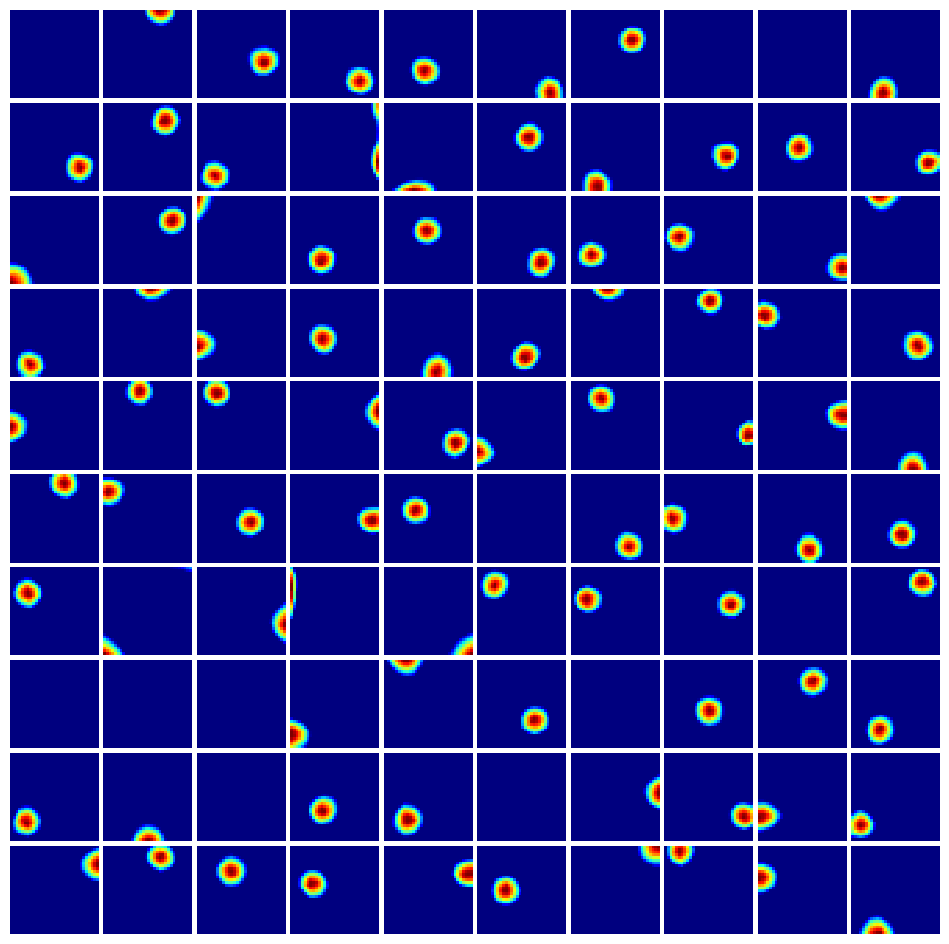

In [4]:
n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)

    ax[row, col].imshow(representation, cmap = "jet", interpolation = "none")

plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [5]:
# assume p is a torch tensor
p0 = torch.tensor(p[0].astype("float32"), requires_grad=False)
A = torch.nn.Parameter((torch.rand((len(p0), len(p0)), dtype=torch.float32) * 2 - 1)*0.001)
R = torch.nn.Parameter((torch.rand((len(p0), len(p0)), dtype=torch.float32) * 2 - 1)*0.001)


# create a torch optimizer
optimizer = torch.optim.Adam([p0], lr=1e-4)
relu = torch.nn.ReLU()
losses = []
steps = 10000
# define a training loop
for _ in tqdm(range(steps)):
    optimizer.zero_grad()
    
    z = R@torch.tensor(p.T)
    b = R.T@R - torch.eye(len(R)) # be orthogonal
    c = R@R.T - torch.eye(len(w0)) # be orthogonal
    d = (torch.linalg.det(R) - 1) # proper rotation
    e = R.T@relu(A@p0) # non-negative result everywhere
    #loss = torch.mean(a**2) + torch.mean(b**2)  + torch.mean(c**2) + torch.mean(d**2) + torch.mean(e) 
    
    loss = torch.mean(b**2)  + torch.mean(c**2) + torch.mean(d**2) +  torch.mean((p0 - e)**2) 
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

plt.semilogy(losses)

NameError: name 'w0' is not defined

In [ ]:
w = w0.detach().numpy()

In [ ]:
(target - w@p[0])**2

tensor([2.7618e-02, 1.4016e-02, 1.6655e-04, 3.3348e-02, 2.5217e-03, 1.6945e-03,
        1.0552e-02, 3.6535e-03, 9.3157e-04, 2.0346e-02, 2.4159e-02, 2.4425e-02,
        9.1507e-06, 2.2091e-02, 4.9656e-03, 7.3809e-06, 1.9543e-02, 1.9821e-02,
        3.4183e-03, 1.8526e-03, 1.2293e-02, 4.5127e-04, 4.2736e-02, 3.7842e-02,
        2.3861e-02, 2.2459e-02, 4.9888e-04, 2.9901e-03, 2.7718e-02, 1.5119e-02,
        1.0003e-02, 1.6281e-02, 8.8910e-03, 6.4365e-03, 1.2465e-03, 2.9835e-02,
        1.5752e-03, 3.3019e-02, 1.7084e-03, 1.0802e-02, 5.4906e-03, 2.7597e-02,
        3.6736e-03, 3.2317e-02, 1.1668e-02, 1.1535e-01, 3.2804e-02, 1.3953e-02,
        3.5654e-02, 1.0391e-02, 2.1637e-02, 1.3246e-03, 1.3474e-02, 2.7276e-04,
        1.2488e-02, 2.9099e-02, 2.6119e-03, 9.3726e-03, 7.6729e-03, 2.1773e-02,
        1.9235e-02, 1.0324e-02, 2.7792e-02, 4.9140e-02, 1.7945e-02, 5.5360e-02,
        2.7337e-03, 1.4282e-03, 4.1652e-03, 1.3951e-02, 2.4674e-01, 2.9534e-03,
        6.7591e-03, 1.4498e-03, 4.4287e-

In [ ]:
np.linalg.det(w)

0.999872

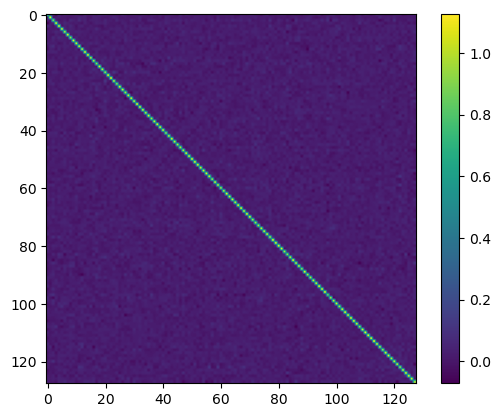

In [ ]:
plt.imshow(w@w.T)
plt.colorbar()

In [ ]:
z = z.detach().numpy()
#z = (w0@torch.tensor(p.T)).detach().numpy()
# z = (w0@torch.tensor(z)).detach().numpy()

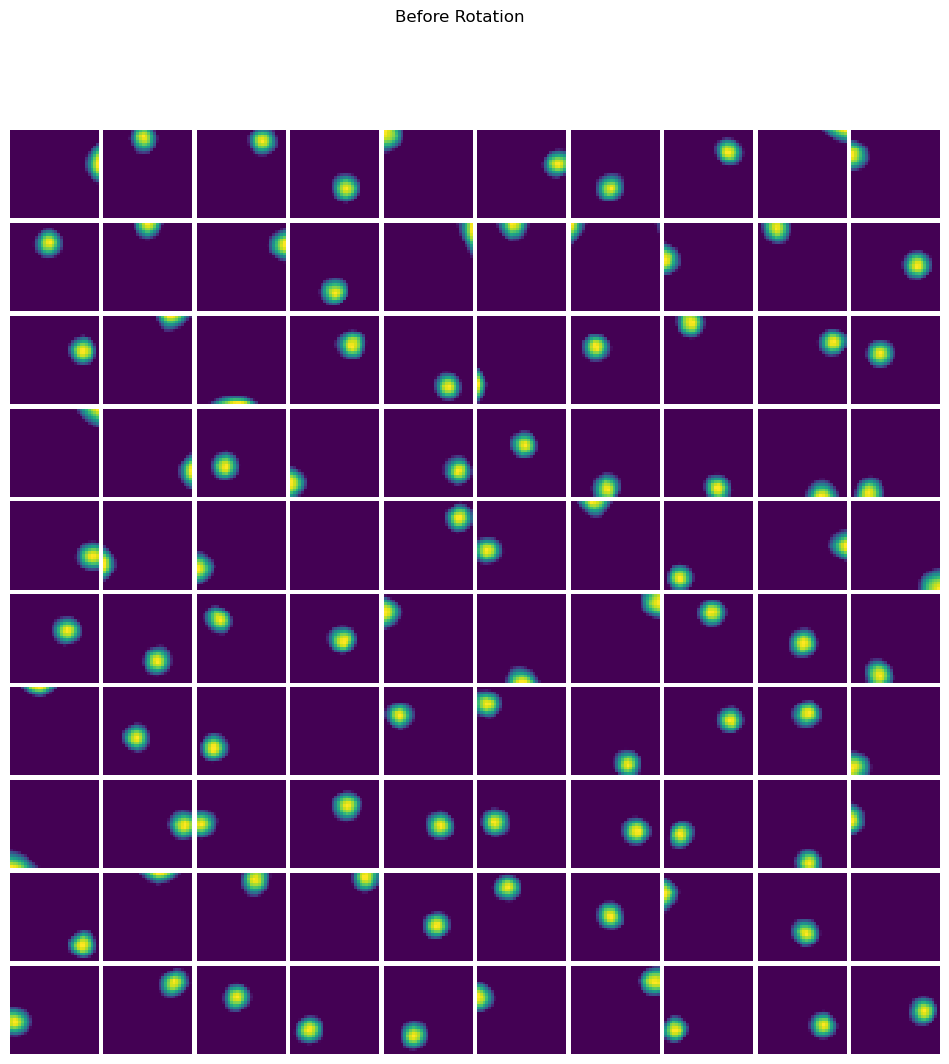

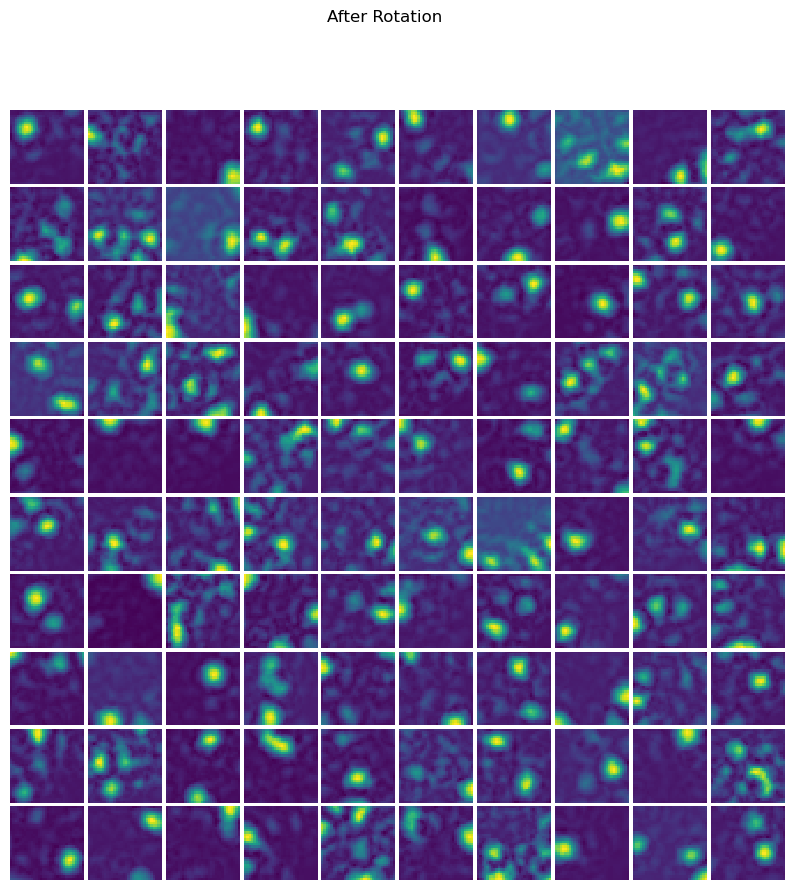

In [ ]:
n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(12, 12))

for i, representation in enumerate(p.T[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)

    ax[row,  col].imshow(representation, interpolation = "none")

plt.suptitle("Before Rotation")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

n_p = 10
fig, ax = plt.subplots(n_p, n_p, figsize =(10, 10))

for i, representation in enumerate(z[:n_p**2]):

    row = i // n_p
    col = i % n_p
    ax[row, col].axis("off")

    representation = representation.reshape(n, n)
    ax[row, col].imshow(representation, interpolation = "none")

plt.suptitle("After Rotation")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

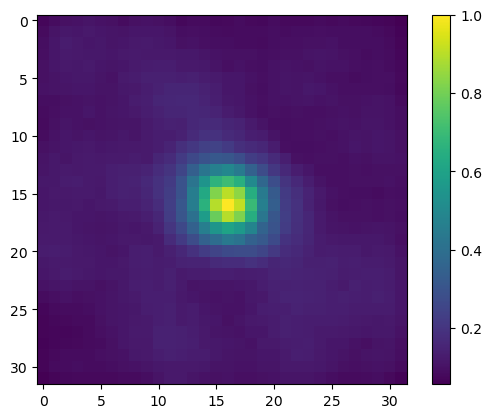

In [ ]:
ps = z[:,512+16]
sim = np.exp(-np.sum((ps[None] - z.T)**2, axis = -1))
plt.imshow(sim.reshape(32,32), interpolation = "None")
plt.colorbar()

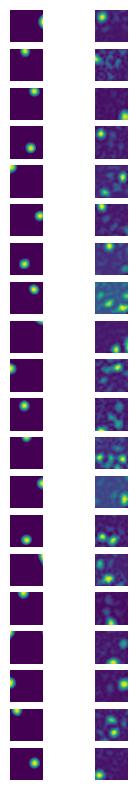

In [ ]:
fig, ax = plt.subplots(20, 2, figsize = (2, 10))

for i in range(20):
    # ax[i,1].imshow(z[i].reshape(32,32),vmax = np.amax(p[:,i]))
    ax[i,1].imshow(z[i].reshape(32,32))#,vmax = np.amax(p[:,i]))

    ax[i, 0].imshow(p[:,i].reshape(32,32))
    ax[i,0].axis("off")
    ax[i,1].axis("off")

\begin{equation}
    p = [Wh]_+
\end{equation}

\begin{equation}
    p = [WAh]_+
\end{equation}